In [ ]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, ConcatDataset
from skimage.metrics import structural_similarity as ssim
from torch_fidelity import calculate_metrics
import tempfile
from torchvision.utils import save_image
from IPython.display import HTML


In [ ]:
# Configuration Parameters

# Root directory for dataset
google_drive_root = '/Users/adityadwivedi/Downloads/chest_xray'  # Replace with your folder structure
dataroot_train = os.path.join(google_drive_root, 'chest_xray', 'train')
dataroot_test = os.path.join(google_drive_root, 'chest_xray', 'test')
dataroot_val = os.path.join(google_drive_root, 'chest_xray', 'val')

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 32  # Changed from 64 to 32

# Number of channels in the training images. For grayscale images this is 1
nc = 1

# Size of z latent vector (i.e., size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 40

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Number of BiLSTM layers
num_lstm_layers = 1

# Hidden size for BiLSTM
hidden_size = 128

# Device configuration
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


Image has 1 channel


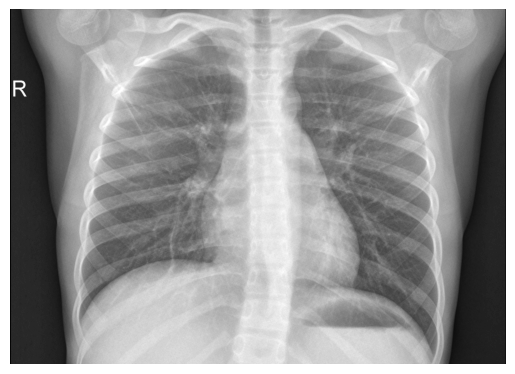

In [ ]:
# Image Validation Function
def check_Image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

# Path to a sample image for visualization
filename = '/Users/adityadwivedi/Downloads/chest_xray/test/NORMAL/IM-0003-0001.jpeg'  # Replace with your folder structure

# Check if the file exists
if not os.path.exists(filename):
    raise FileNotFoundError(f"File not found: {filename}")

# Open image using PIL
im = Image.open(filename)

# Convert to numpy array
img = np.array(im)

# Find number of channels
if img.ndim == 2:
    channels = 1
    print("Image has 1 channel")
else:
    channels = img.shape[-1]
    print("Image has", channels, "channels")

# Display the image
plt.imshow(im, cmap='gray' if channels == 1 else None)
plt.axis('off')
plt.show()


In [ ]:
# Define the datasets
dataset_train = dset.ImageFolder(root=dataroot_train,
                                 is_valid_file=check_Image,
                                 transform=transforms.Compose([
                                     transforms.Grayscale(num_output_channels=1),
                                     transforms.Resize(image_size),
                                     transforms.CenterCrop(image_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,)),  # Normalizes to [-1, 1]
                                 ]))

dataset_test = dset.ImageFolder(root=dataroot_test,
                                is_valid_file=check_Image,
                                transform=transforms.Compose([
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,)),
                                ]))

dataset_val = dset.ImageFolder(root=dataroot_val,
                               is_valid_file=check_Image,
                               transform=transforms.Compose([
                                   transforms.Grayscale(num_output_channels=1),
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (0.5,)),
                               ]))

# Combine datasets
image_datasets = ConcatDataset([dataset_train, dataset_test, dataset_val])

# Create dataloader
dataloader = DataLoader(image_datasets, batch_size=batch_size,
                        shuffle=True, num_workers=workers)


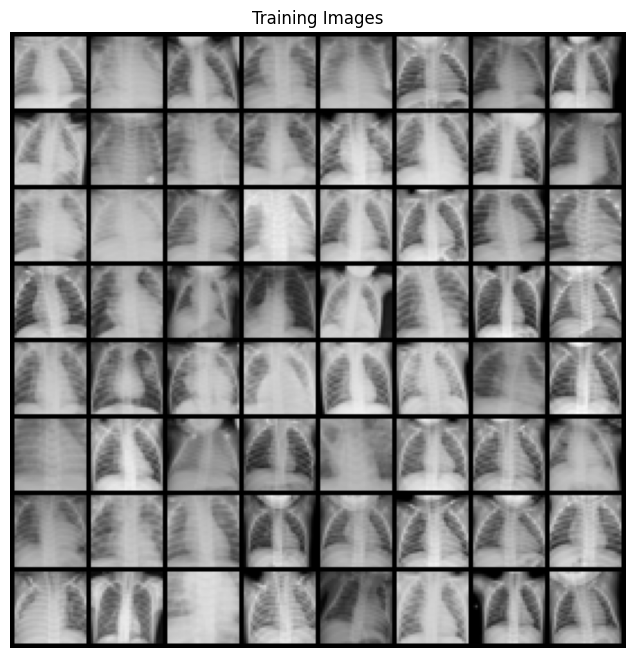

In [ ]:
# Visualize some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
# Only display first 64 images
grid = vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True)
plt.imshow(np.transpose(grid.cpu(),(1,2,0)), cmap='gray')
plt.show()


In [ ]:
# Weight initialization function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [ ]:
# Corrected BiLSTM DCGAN Generator to output 32x32 images
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc, hidden_size, num_lstm_layers=1):
        super(Generator, self).__init__()
        self.ngf = ngf
        self.hidden_size = hidden_size
        self.num_lstm_layers = num_lstm_layers

        self.main = nn.Sequential(
            # Input: Z latent vector (nz x1 x1)
            nn.ConvTranspose2d(in_channels = nz,
                               out_channels = ngf * 8,
                               kernel_size = 4,
                               stride = 1,
                               padding = 0,
                               bias=False),
            nn.BatchNorm2d(num_features = ngf * 8),
            nn.ReLU(True),
            # State: (ngf*8) x4x4

            nn.ConvTranspose2d(in_channels = ngf * 8,
                               out_channels = ngf * 4,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias=False),
            nn.BatchNorm2d(num_features = ngf * 4),
            nn.ReLU(True),
            # State: (ngf*4) x8x8

            nn.ConvTranspose2d(in_channels = ngf * 4,
                               out_channels = ngf * 2,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias=False),
            nn.BatchNorm2d(num_features = ngf * 2),
            nn.ReLU(True),
            # State: (ngf*2) x16x16
        )

        # Define LSTM layers
        # Process sequences along the width for each channel and height
        # Flatten height and process sequences along width
        self.lstm = nn.LSTM(input_size=ngf * 2, hidden_size=hidden_size,
                            num_layers=num_lstm_layers, batch_first=True, bidirectional=True)

        # After LSTM, project back to feature maps
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, ngf * 2 * 4 * 4),  # bidirectional
            nn.BatchNorm1d(ngf * 2 * 4 * 4),
            nn.ReLU(True),
        )

        # Upsampling layers to reach 32x32
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(in_channels = ngf * 2,
                               out_channels = ngf,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias=False),
            nn.BatchNorm2d(num_features = ngf),
            nn.ReLU(True),
            # State: (ngf) x32x32

            nn.ConvTranspose2d(in_channels = ngf,
                               out_channels = ngf // 2,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias=False),
            nn.BatchNorm2d(num_features = ngf // 2),
            nn.ReLU(True),
            # State: (ngf//2) x64x64

            nn.ConvTranspose2d(in_channels = ngf // 2,
                               out_channels = nc,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias=False),
            nn.Tanh()
            # Output: (nc) x128x128
        )

    def forward(self, input):
        x = self.main(input)  # (batch_size, ngf*2,16,16)
        batch_size, channels, height, width = x.size()
        # Reshape for LSTM: (batch_size, sequence_length=width*height, input_size=channels)
        x = x.view(batch_size, channels, height * width)  # (batch_size, ngf*2,256)
        x = x.permute(0, 2, 1)  # (batch_size,256, ngf*2)
        # Apply LSTM
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size,256, hidden_size*2)
        # Take the last output
        lstm_out = lstm_out[:, -1, :]  # (batch_size, hidden_size*2)
        # Pass through fully connected layer
        fc_out = self.fc(lstm_out)  # (batch_size, ngf*2 *4 *4)
        # Reshape to (batch_size, ngf*2,4,4)
        fc_out = fc_out.view(batch_size, self.ngf * 2, 4, 4)
        # Upsample to 128x128
        out = self.upsample(fc_out)  # (batch_size, nc,128,128)
        return out


In [ ]:
# Create the generator
netG = Generator(nz=nz, ngf=ngf, nc=nc, hidden_size=hidden_size, num_lstm_layers=num_lstm_layers).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
netG.apply(weights_init)

# Print the Generator model
print(netG)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (upsample): Sequential(
    (0): ConvTranspose2d(128, 64, ke

In [ ]:
# Corrected BiLSTM DCGAN Discriminator with Sigmoid Activation
class Discriminator(nn.Module):
    def __init__(self, nc, ndf, hidden_size, num_lstm_layers=1):
        super(Discriminator, self).__init__()
        self.ndf = ndf
        self.hidden_size = hidden_size
        self.num_lstm_layers = num_lstm_layers

        self.main = nn.Sequential(
            # Input: (nc) x32x32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: (ndf) x16x16

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: (ndf*2) x8x8

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: (ndf*4) x4x4
        )

        # Define LSTM layers
        self.lstm = nn.LSTM(input_size=ndf * 4, hidden_size=hidden_size,
                            num_layers=num_lstm_layers, batch_first=True, bidirectional=True)

        # After LSTM, project to scalar with Sigmoid activation
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 1),  # bidirectional
            nn.Sigmoid()  # Ensures output is between 0 and 1
        )

    def forward(self, input):
        x = self.main(input)  # (batch_size, ndf*4,4,4)
        batch_size, channels, height, width = x.size()
        # Reshape for LSTM: (batch_size, sequence_length=height*width, input_size=channels)
        x = x.view(batch_size, channels, height * width)  # (batch_size, ndf*4,16)
        x = x.permute(0, 2, 1)  # (batch_size,16,ndf*4)
        # Apply LSTM
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size,16, hidden_size*2)
        # Take the last output
        lstm_out = lstm_out[:, -1, :]  # (batch_size, hidden_size*2)
        # Pass through fully connected layer with Sigmoid
        out = self.fc(lstm_out)  # (batch_size,1)
        return out.squeeze(1)  # (batch_size)


In [ ]:
# Create the Discriminator
netD = Discriminator(nc=nc, ndf=ndf, hidden_size=hidden_size, num_lstm_layers=num_lstm_layers).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
netD.apply(weights_init)

# Print the Discriminator model
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (lstm): LSTM(256, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [ ]:
# Function to compute PSNR
def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

# Function to compute SSIM
def calculate_ssim(img1, img2):
    img1 = img1.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to Numpy (BCHW to BHWC)
    img2 = img2.cpu().numpy().transpose(0, 2, 3, 1)

    ssim_values = []
    for i in range(img1.shape[0]):
        height, width, _ = img1[i].shape
        min_dim = min(height, width)
        win_size = min(7, min_dim) if min_dim >= 3 else 3  # Ensure a minimum of 3x3 window

        ssim_val = ssim(
            img1[i],
            img2[i],
            win_size=win_size,
            data_range=1.0,   # Assuming pixel values are normalized to [0, 1]
            channel_axis=-1   # Explicitly set the axis for color channels
        )
        ssim_values.append(ssim_val)

    return np.mean(ssim_values)

# Function to compute FID
def calculate_fid_score(real_images, fake_images):
    """
    Calculate the FID score between real and fake images using torch_fidelity.

    Parameters:
        real_images (torch.Tensor): Real images (B, C, H, W) normalized to [0, 1].
        fake_images (torch.Tensor): Fake images (B, C, H, W) normalized to [0, 1].

    Returns:
        float: The FID score.
    """
    real_images = (real_images * 255).byte()  # Convert to [0, 255] range
    fake_images = (fake_images * 255).byte()

    # Save real and fake images as temporary folders
    with tempfile.TemporaryDirectory() as real_dir, tempfile.TemporaryDirectory() as fake_dir:
        # Save images to their respective folders
        for i, img in enumerate(real_images):
            save_image(img.float() / 255.0, f"{real_dir}/real_{i}.png")
        for i, img in enumerate(fake_images):
            save_image(img.float() / 255.0, f"{fake_dir}/fake_{i}.png")

        # Calculate FID using the saved folders
        metrics = calculate_metrics(
            input1=real_dir,
            input2=fake_dir,
            cuda=torch.cuda.is_available(),
            fid=True  # Enable FID computation
        )
    return metrics["frechet_inception_distance"]


In [ ]:
# Initialize lists to track metrics and losses
fid_scores = []
psnr_scores = []
ssim_scores = []

img_list = []
G_losses = []
D_losses = []
iters = 0


In [ ]:
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                # Set generator to evaluation mode to handle BatchNorm correctly
                netG.eval()
                fake = netG(fixed_noise).detach().cpu()
                real_images = data[0].cpu()[:fake.size(0)]  # Slice to match fake batch size
                # Set back to training mode
                netG.train()

            # Denormalize images from [-1,1] to [0,1]
            real_images_denorm = (real_images + 1) / 2
            fake_denorm = (fake + 1) / 2

            # Calculate PSNR
            psnr_score = calculate_psnr(real_images_denorm, fake_denorm)
            psnr_scores.append(psnr_score)

            # Calculate SSIM
            ssim_score = calculate_ssim(real_images_denorm, fake_denorm)
            ssim_scores.append(ssim_score)

            # Calculate FID
            fid_score = calculate_fid_score(real_images_denorm, fake_denorm)
            fid_scores.append(fid_score)

            # Save generated images for visualization
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/40][0/46]	Loss_D: 1.3791	Loss_G: 0.7429	D(x): 0.5007	D(G(z)): 0.4968 / 0.4759


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmpsgkrpgth" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h00

[1/40][0/46]	Loss_D: 0.2830	Loss_G: 2.3532	D(x): 0.8786	D(G(z)): 0.1330 / 0.0957
[2/40][0/46]	Loss_D: 0.0692	Loss_G: 3.3148	D(x): 0.9793	D(G(z)): 0.0468 / 0.0376
[3/40][0/46]	Loss_D: 0.0359	Loss_G: 3.9030	D(x): 0.9910	D(G(z)): 0.0264 / 0.0205
[4/40][0/46]	Loss_D: 0.3533	Loss_G: 2.7426	D(x): 0.8832	D(G(z)): 0.1913 / 0.0673
[5/40][0/46]	Loss_D: 1.2600	Loss_G: 1.3550	D(x): 0.4303	D(G(z)): 0.2428 / 0.5011
[6/40][0/46]	Loss_D: 1.1600	Loss_G: 1.6652	D(x): 0.6394	D(G(z)): 0.4374 / 0.2228
[7/40][0/46]	Loss_D: 0.7884	Loss_G: 1.5273	D(x): 0.6696	D(G(z)): 0.2962 / 0.2305
[8/40][0/46]	Loss_D: 1.1150	Loss_G: 2.0869	D(x): 0.7777	D(G(z)): 0.5523 / 0.1401
[9/40][0/46]	Loss_D: 1.0055	Loss_G: 1.4061	D(x): 0.6366	D(G(z)): 0.3785 / 0.2690
[10/40][0/46]	Loss_D: 1.3595	Loss_G: 0.9479	D(x): 0.4804	D(G(z)): 0.4136 / 0.4002


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmp38bvz7p6" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h00

[11/40][0/46]	Loss_D: 1.2604	Loss_G: 1.2465	D(x): 0.4389	D(G(z)): 0.2265 / 0.3108
[12/40][0/46]	Loss_D: 0.9765	Loss_G: 1.2346	D(x): 0.5851	D(G(z)): 0.2925 / 0.3039
[13/40][0/46]	Loss_D: 1.2242	Loss_G: 2.1548	D(x): 0.6488	D(G(z)): 0.4957 / 0.1286
[14/40][0/46]	Loss_D: 2.1428	Loss_G: 2.5055	D(x): 0.3340	D(G(z)): 0.2235 / 0.0933
[15/40][0/46]	Loss_D: 1.3203	Loss_G: 0.8197	D(x): 0.4183	D(G(z)): 0.2297 / 0.4560
[16/40][0/46]	Loss_D: 1.3332	Loss_G: 1.1040	D(x): 0.3884	D(G(z)): 0.2080 / 0.3533
[17/40][0/46]	Loss_D: 1.2537	Loss_G: 1.6949	D(x): 0.6745	D(G(z)): 0.5272 / 0.2009
[18/40][0/46]	Loss_D: 1.1534	Loss_G: 2.0311	D(x): 0.7653	D(G(z)): 0.5560 / 0.1513
[19/40][0/46]	Loss_D: 0.7995	Loss_G: 1.8828	D(x): 0.7349	D(G(z)): 0.3405 / 0.1729
[20/40][0/46]	Loss_D: 1.0776	Loss_G: 1.2958	D(x): 0.5554	D(G(z)): 0.3076 / 0.3004
[21/40][0/46]	Loss_D: 0.8035	Loss_G: 1.9117	D(x): 0.6975	D(G(z)): 0.3032 / 0.1642


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmpskldb6zd" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h00

[22/40][0/46]	Loss_D: 1.0171	Loss_G: 1.6490	D(x): 0.5980	D(G(z)): 0.2953 / 0.2197
[23/40][0/46]	Loss_D: 0.9194	Loss_G: 1.7121	D(x): 0.6700	D(G(z)): 0.3154 / 0.1968
[24/40][0/46]	Loss_D: 1.0425	Loss_G: 1.6259	D(x): 0.6165	D(G(z)): 0.3478 / 0.2486
[25/40][0/46]	Loss_D: 1.0185	Loss_G: 1.8836	D(x): 0.7575	D(G(z)): 0.4899 / 0.1718
[26/40][0/46]	Loss_D: 0.8747	Loss_G: 2.3995	D(x): 0.7092	D(G(z)): 0.3346 / 0.1032
[27/40][0/46]	Loss_D: 1.1218	Loss_G: 2.0831	D(x): 0.7754	D(G(z)): 0.5099 / 0.1391
[28/40][0/46]	Loss_D: 0.8923	Loss_G: 1.7060	D(x): 0.6444	D(G(z)): 0.2838 / 0.2028
[29/40][0/46]	Loss_D: 1.0175	Loss_G: 2.4408	D(x): 0.8503	D(G(z)): 0.5201 / 0.0998
[30/40][0/46]	Loss_D: 0.9565	Loss_G: 1.4766	D(x): 0.6351	D(G(z)): 0.3462 / 0.2386
[31/40][0/46]	Loss_D: 1.4041	Loss_G: 1.5015	D(x): 0.3893	D(G(z)): 0.1452 / 0.3240
[32/40][0/46]	Loss_D: 0.7482	Loss_G: 1.8825	D(x): 0.7335	D(G(z)): 0.3099 / 0.1612


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmpvd2k86rd" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h00

[33/40][0/46]	Loss_D: 1.2015	Loss_G: 2.4048	D(x): 0.8239	D(G(z)): 0.5356 / 0.1198
[34/40][0/46]	Loss_D: 0.7735	Loss_G: 1.8912	D(x): 0.7138	D(G(z)): 0.3061 / 0.1593
[35/40][0/46]	Loss_D: 1.1350	Loss_G: 2.2010	D(x): 0.4861	D(G(z)): 0.1186 / 0.1573
[36/40][0/46]	Loss_D: 0.9412	Loss_G: 1.7323	D(x): 0.6586	D(G(z)): 0.3351 / 0.2013
[37/40][0/46]	Loss_D: 0.9247	Loss_G: 2.0361	D(x): 0.6937	D(G(z)): 0.3601 / 0.1536
[38/40][0/46]	Loss_D: 0.8677	Loss_G: 2.2468	D(x): 0.7975	D(G(z)): 0.3977 / 0.1181
[39/40][0/46]	Loss_D: 0.8869	Loss_G: 1.9252	D(x): 0.7174	D(G(z)): 0.3811 / 0.1570


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/tmpp03yoe4b" with extensions png,jpg,jpeg
Found 64 samples
Processing samples:   0%|          | 0/64 [00:00<?, ?samples/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "/var/folders/7d/vzx818195gndjk3505n2d51h00

In [ ]:
# Verify the Generator's output size
netG.eval()  # Set to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    sample_noise = torch.randn(1, nz, 1, 1, device=device)
    sample_fake = netG(sample_noise)
print("Generator output shape:", sample_fake.shape)  # Should be (1, nc, 128, 128)
netG.train()  # Set back to training mode


Generator output shape: torch.Size([1, 1, 32, 32])


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (upsample): Sequential(
    (0): ConvTranspose2d(128, 64, ke

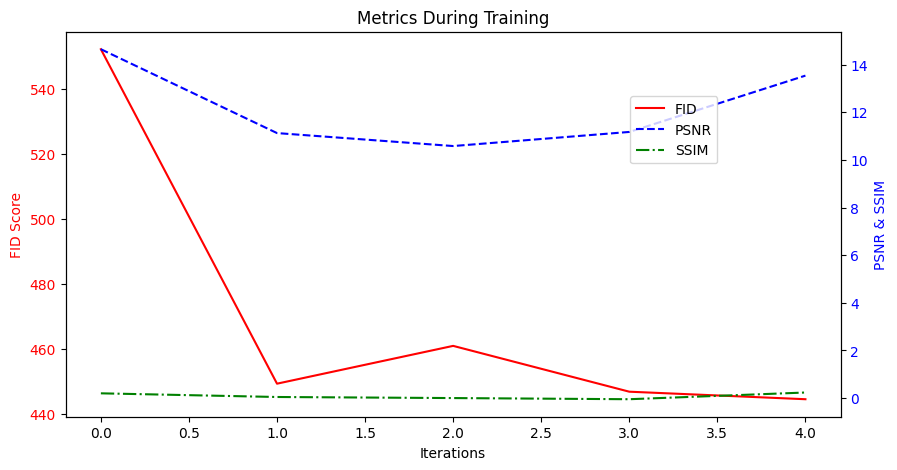

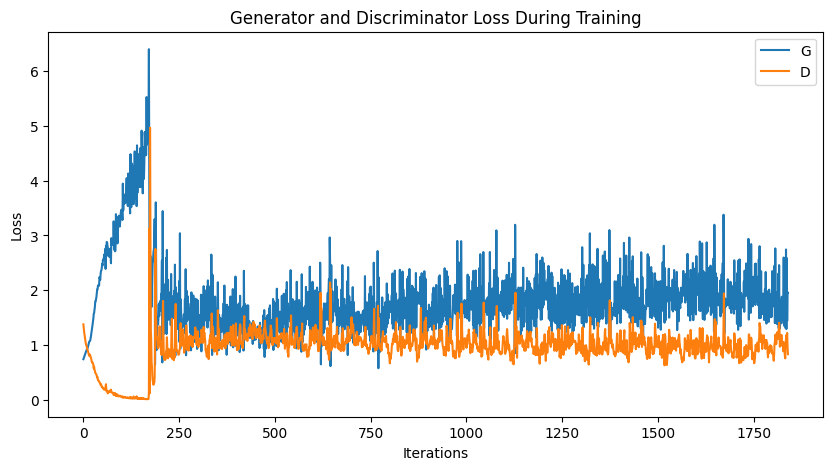

In [ ]:
# Plot Metrics
import matplotlib.pyplot as plt

# Plot FID on the left y-axis
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_title("Metrics During Training")
ax1.plot(fid_scores, label="FID", color="red")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("FID Score", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Create a twin y-axis for PSNR and SSIM
ax2 = ax1.twinx()
ax2.plot(psnr_scores, label="PSNR", color="blue", linestyle="--")
ax2.plot(ssim_scores, label="SSIM", color="green", linestyle="-.")
ax2.set_ylabel("PSNR & SSIM", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Add legends for both y-axes
fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.85), bbox_transform=ax1.transAxes)

plt.show()

# Plot Generator and Discriminator Loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


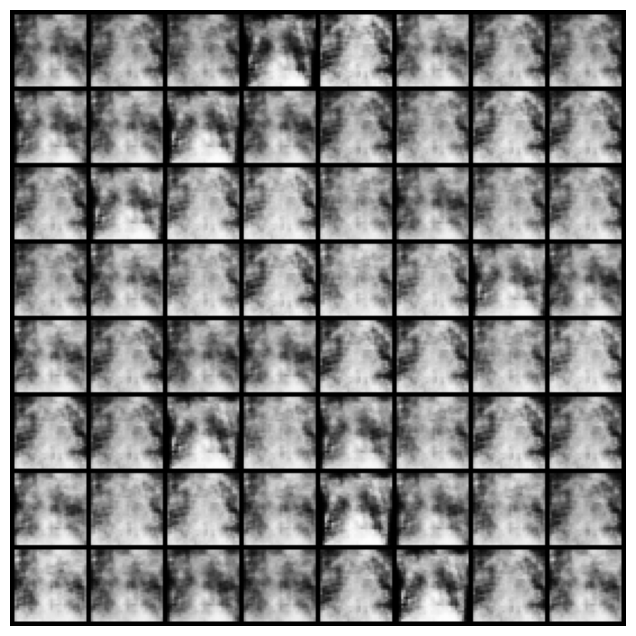

In [ ]:
# Generate and display the animation of generated images
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

